# Reproduce init process for 2-qubit system

Let's have a random 16-dimensional real-valued vector. This vector can be encoded with 4 qubits. We will show this in the section.

In [1]:
import numpy as np

N = 4
raw = np.random.rand(2 ** N).astype(np.float64)
norm = sum(raw * raw) ** .5
psi = raw / norm
print("State we want to initialize:", psi)
assert np.allclose(sum(psi * psi), 1.0)

State we want to initialize: [0.06677253 0.27036408 0.3479627  0.23796887 0.12612749 0.1180848
 0.00815921 0.15089068 0.27373816 0.22586141 0.10442875 0.0426155
 0.47382973 0.36088178 0.41942261 0.15072401]


Here we run `initalize()` method of qiskit, which is old enough, but is proven to be asymptotically optimal.

In [2]:
from qiskit import BasicAer, QuantumCircuit, QuantumRegister, execute, transpile
SVSIM = BasicAer.get_backend('statevector_simulator')

qr = QuantumRegister(N, name="q")
qc = QuantumCircuit(qr)
qc.initialize(psi)

job = execute(qc, backend=SVSIM)
vector = job.result().get_statevector()
print(vector)

[0.06677253-1.30500651e-17j 0.27036408+3.18427863e-16j
 0.3479627 +3.66265789e-16j 0.23796887+3.19393489e-16j
 0.12612749+2.08714058e-16j 0.1180848 +1.63379288e-16j
 0.00815921+5.67113818e-17j 0.15089068+1.70207802e-16j
 0.27373816+3.84384938e-16j 0.22586141+2.63457248e-16j
 0.10442875+1.75266592e-16j 0.0426155 +8.59965281e-17j
 0.47382973+6.25127242e-16j 0.36088178+3.85760700e-16j
 0.41942261+3.88273250e-16j 0.15072401+1.95499150e-16j]


Here we show, that the obtained state is exactly the one we wanted to observe.

In [3]:
from qiskit.quantum_info import state_fidelity
print(f"State fidelity: {state_fidelity(psi, vector):.4f}")

State fidelity: 1.0000


Let us see, what is the ciruit implementing this.

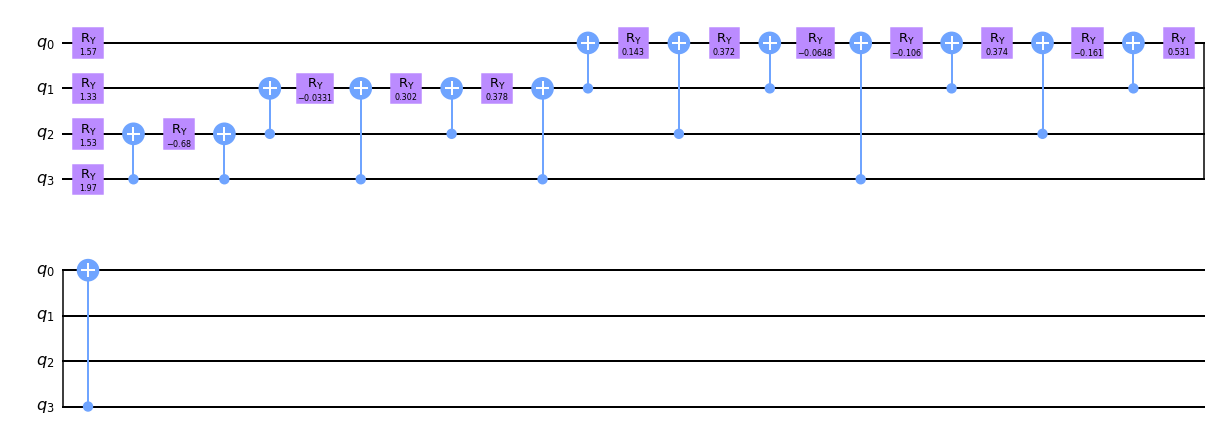

In [4]:
qct = transpile(
    qc, 
    backend=SVSIM, 
    basis_gates=['h', 'cx', 'u1', 'u2', 'u3', 'rx', 'ry', 'rz'])
qct.draw(output='mpl')

But just to write down 16 numbers, we needed 14 $CNOT$ gates, which make it useless in NISQ system of 2022. In physical computers this state will be already significantly corrupted.

In [5]:
print(f"Depth: {qct.depth()}, "
      f"CX count: {qct.count_ops()['cx']}, "
      f"Fidelity: {state_fidelity(psi, vector):.4f}")

Depth: 26, CX count: 14, Fidelity: 1.0000


# Decomposition idea

It is fun, that tensor and matrix multiplications are the same in terms of elements, but they have a different shape!

In [6]:
from sympy import Matrix, symbols
a, b, c, d, e, f, g, h = symbols('a,b,c,d,e,f,g,h')
q1 = Matrix([a, b, c, d])
q2 = Matrix([e, f, g, h])
MM = q1 * q2.T
TM = Matrix([a * q2, b * q2, c * q2, d * q2 ])
print("Matrix multiplication")
display(MM)
print("Tensor multiplication")
display(TM)

Matrix multiplication


Matrix([
[a*e, a*f, a*g, a*h],
[b*e, b*f, b*g, b*h],
[c*e, c*f, c*g, c*h],
[d*e, d*f, d*g, d*h]])

Tensor multiplication


Matrix([
[a*e],
[a*f],
[a*g],
[a*h],
[b*e],
[b*f],
[b*g],
[b*h],
[c*e],
[c*f],
[c*g],
[c*h],
[d*e],
[d*f],
[d*g],
[d*h]])

In [7]:
assert TM.reshape(4, 4) == MM, "they are composed of the same values!"

We will use this to do a cool trick.

To find an approximate tensor decomposition 

$|\Psi\rangle\approx|q_0\rangle\otimes|q_1\rangle$, 

use SVD of an equivalent square matrix 

$|\Psi\rangle$.`reshape(4, 4)` into $q_0\times q_1^T$!
 
Sooo, what if we decompose our vector with SVD?

In [8]:
# decompose 
psi_M = psi.reshape(2 ** (N // 2), 2 ** (N // 2))
U, s, Vh = np.linalg.svd(psi_M)

#take 0th principal dimension
q0 = (U @ np.diag(s))[:, 0].reshape(psi_M.shape[0], 1)
# norm it to the valid quantum state
norm = sum(q0 * q0) ** .5
q0 /= norm

#take 2st principal dimension
q1 = Vh[0, :].reshape(psi_M.shape[0], 1)
# norm it to the valid quantum state
norm = sum(q1 * q1) ** .5
q1 /= norm

# do these objects consist of the same values?
assert np.allclose((q0 @ q1.T).reshape(-1), np.kron(q0, q1).reshape(-1))

how good were we in this particular state?

In [9]:
state_fidelity(psi, np.kron(q0, q1))

0.8964842347227431

And now we can split our 4-qubit initialize algirothm into 2 parallel 2-qubit initializiations:

In [10]:
qr_approx = QuantumRegister(N, name="q")
qc_approx = QuantumCircuit(qr_approx)

qc_approx.initialize(q0.reshape(-1), range(N // 2, N))
qc_approx.initialize(q1.reshape(-1), range(0, N // 2))

job = execute(qc_approx, backend=SVSIM)
vector_approx = job.result().get_statevector()
print(vector_approx)

[0.26206203+4.07938625e-17j 0.25673774+3.99650577e-17j
 0.26515551+4.12754084e-17j 0.13712375+2.13453559e-17j
 0.10668265+4.83529763e-17j 0.10451519+4.73705938e-17j
 0.10794197+4.89237528e-17j 0.05582161+2.53006562e-17j
 0.20199301+8.88598416e-17j 0.19788914+8.70544852e-17j
 0.20437741+8.99087761e-17j 0.10569268+4.64958411e-17j
 0.43144209+6.82561654e-17j 0.42267653+6.68694118e-17j
 0.43653499+6.90618865e-17j 0.22575173+3.57149840e-17j]


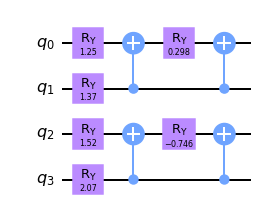

In [11]:
qcta = transpile(
    qc_approx, 
    backend=SVSIM, 
    basis_gates=['h', 'cx', 'u1', 'u2', 'u3', 'rx', 'ry', 'rz'])
qcta.draw(output='mpl')

In [12]:
print(f"Depth: {qcta.depth()}, "
      f"CX count: {qcta.count_ops()['cx']}, "
      f"Fidelity: {state_fidelity(psi, vector_approx):.4f}")

Depth: 4, CX count: 4, Fidelity: 0.8965


# How good is the method for a random vector?

In [13]:
from tqdm import tqdm
fidelities = []

for i in tqdm(range(10000)):
    raw = np.random.rand(2 ** N).astype(np.float64)
    norm = sum(raw * raw) ** .5
    psi = raw / norm
    
    psi_M = psi.reshape(2 ** (N // 2), 2 ** (N // 2))
    U, s, Vh = np.linalg.svd(psi_M)
    q0 = (U @ np.diag(s))[:, 0].reshape(psi_M.shape[0], 1)
    norm = sum(q0 * q0) ** .5
    q0 /= norm
    q1 = Vh[0, :].reshape(psi_M.shape[0], 1)
    norm = sum(q1 * q1) ** .5
    q1 /= norm
    qr_approx = QuantumRegister(N, name="q")
    qc_approx = QuantumCircuit(qr_approx)

    qc_approx.initialize(q0.reshape(-1), range(N // 2, N))
    qc_approx.initialize(q1.reshape(-1), range(0, N // 2))

    job = execute(qc_approx, backend=SVSIM)
    vector_approx = job.result().get_statevector()
    fidelities.append(state_fidelity(psi, vector_approx))

100%|██████████| 10000/10000 [02:16<00:00, 73.13it/s]


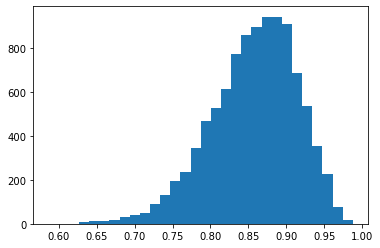

In [14]:
import matplotlib.pyplot as plt
_ = plt.hist(fidelities, bins=30)